#### Testing speed of backpropagation vs speed of forward mode

The test will be for a single lane split into many different segments (and thus junctions with one incoming and one outgoing road) with different speeds. 
There will only be one single objective function, i.e. sum of densities at end of simulation.

In [5]:
import sys
sys.path.append('../src')

import network as nw
import torch
import road as rd
import junction as jn
import initial_and_bc as ibc
from torch.func import jacfwd
from torch.autograd.functional import jacobian
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import contextlib

#### Forward mode:
One single road split into 256 segments

In [6]:
n = 256
T = 30
def create_network(speeds):
    roads = []
    for i in range(n):
        if i == 0:
            # Add boundary function:
            boundary_fnc = ibc.boundary_conditions(1, max_dens = 1, densities = torch.tensor([0.2]),
                                           time_jumps = [], in_speed = torch.tensor(50.0 / 3.6),
                                           L = 50)
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6]), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)
            
        else:
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6]), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=None)
            
            roads.append(road)

    for i in range(len(speeds)):
        roads[i].Vmax[0] = speeds[i]

    junctions = []
    for i in range(n-1):
        junction = jn.Junction([roads[i], roads[i+1]], [0], [1], [[1.0]], [], [])
        junctions.append(junction)

    
    network = nw.RoadNetwork(roads, junctions, T)
    densities, _, _, _ = network.solve_cons_law()
    print(len(densities[0]))

    objective_fnc = torch.tensor(0.0)

    for road in network.roads:
        objective_fnc += torch.sum(road.rho)
    print(objective_fnc)

    return objective_fnc

n = 256
T = 30
def create_bwd_network(n_params):
    # Assume n_params > 0
    roads = []
    for i in range(n):
        if i == 0:
            boundary_fnc = ibc.boundary_conditions(1, max_dens = 1, densities = torch.tensor([0.2]),
                                           time_jumps = [], in_speed = torch.tensor(50.0 / 3.6),
                                           L = 50)
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=True), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)
        elif i < n_params:
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=True), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)
        else:
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=False), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)

    junctions = []
    for i in range(n-1):
        junction = jn.Junction([roads[i], roads[i+1]], [0], [1], [[1.0]], [], [])
        junctions.append(junction)

    
    network = nw.RoadNetwork(roads, junctions, T)
    densities, _, _, _ = network.solve_cons_law()
    print(len(densities[0]))

    objective_fnc = torch.tensor(0.0)

    for road in network.roads:
        objective_fnc += torch.sum(road.rho)
    print(objective_fnc)
    objective_fnc.backward()

    return objective_fnc


n = 256
T = 30
def create_network_nograd():
    # Assume n_params > 0
    roads = []
    for i in range(n):
        if i == 0:
            boundary_fnc = ibc.boundary_conditions(1, max_dens = 1, densities = torch.tensor([0.2]),
                                           time_jumps = [], in_speed = torch.tensor(50.0 / 3.6),
                                           L = 50)
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=False), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)
        else:
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=False), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)

    junctions = []
    for i in range(n-1):
        junction = jn.Junction([roads[i], roads[i+1]], [0], [1], [[1.0]], [], [])
        junctions.append(junction)

    
    network = nw.RoadNetwork(roads, junctions, T)
    densities, _, _, _ = network.solve_cons_law()
    print(len(densities[0]))

    objective_fnc = torch.tensor(0.0)

    for road in network.roads:
        objective_fnc += torch.sum(road.rho)
    print(objective_fnc)

    return objective_fnc

100%|██████████| 8/8 [15:59<00:00, 119.94s/it]


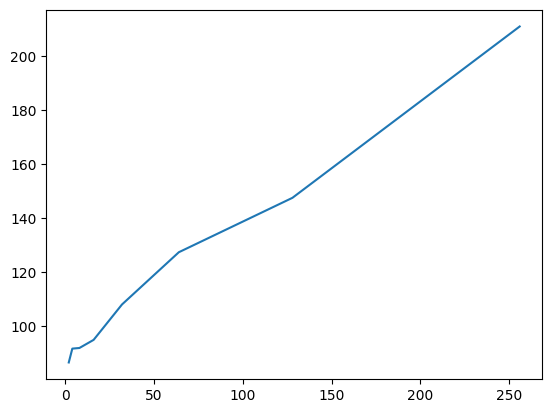

In [7]:
fwd_times = []
forward_sizes = 2**np.arange(1, 9)
for i in tqdm(forward_sizes):
    with contextlib.redirect_stdout(None):
        speeds = torch.ones(i) * (50 / 3.6)
        start = time.time()
        # jacobian = jacfwd(create_network)(speeds)
        jacobian(create_network, speeds, vectorize=True, strategy="forward-mode")
        endtime = time.time()
    fwd_times.append(endtime-start)
plt.plot(forward_sizes, fwd_times)

##### Backward mode:

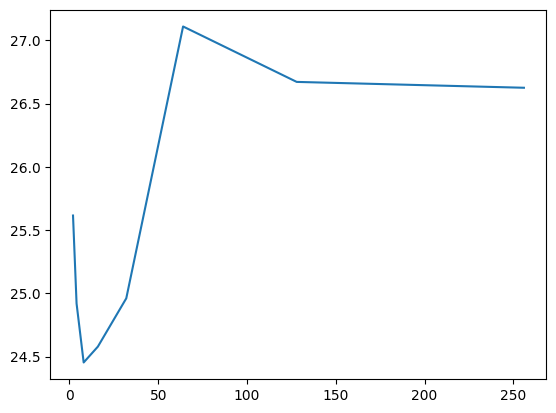

In [12]:
bwd_times = []
backward_sizes = 2**np.arange(1, 9)
for i in tqdm(backward_sizes):
    with contextlib.redirect_stdout(None):
        start = time.time()
        create_bwd_network(i)
        endtime = time.time()
    bwd_times.append(endtime-start)
plt.plot(backward_sizes, bwd_times)

##### No grad:

In [13]:
start = time.time()
create_network_nograd()
endtime = time.time()
no_grad_time = endtime - start

26
tensor(460.7989)


Text(0, 0.5, 'Runtime [s]')

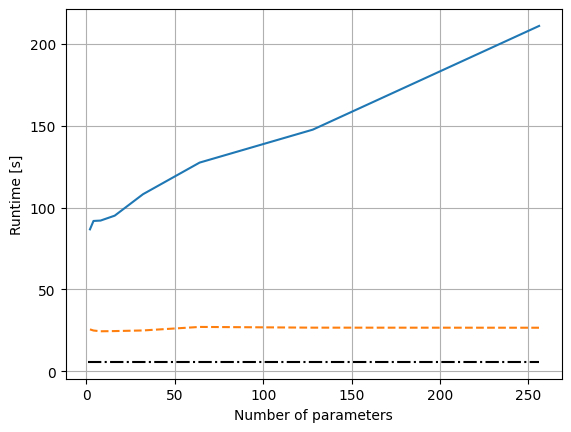

In [15]:
plt.plot(forward_sizes, fwd_times, '-')
plt.plot(backward_sizes, bwd_times, '--')
plt.plot([1, np.max([np.max(forward_sizes), np.max(backward_sizes)])], [no_grad_time, no_grad_time], 'k-.')

plt.grid()
plt.xlabel("Number of parameters")
plt.ylabel("Runtime [s]")